# **TFM: Optimización de la Programación de Producción en una Fábrica de Motores mediante Algoritmos de Optimización.**

Este notebook ha sido desarrollado por Manuel Alejandro Suárez Calle e Inés Teresa Hernández Pastor en colaboración con Navantia para el Trabajo de Fin de Máster del máster en Big Data Science de la Universidad de Navarra.

*Última actualización: 22 de agosto de 2024*

# **Objetivo principal**

 El proyecto tiene como objetivo simular diferentes escenarios de una planta de producción de motores con la finalidad de investigar y desarrollar algoritmos de optimización de la producción, ofreciendo una alternativa al módulo de Advanced Planned and Optimization (APO) de SAP S/4 HANA. Con el enfoque puesto en mejorar la eficiencia y la efectividad en la programación de la producción, se tiene en cuenta información sobre las operaciones, los puestos de trabajo y los recursos disponibles en la planta de fabricación.

## Librerías necesarias

En primer lugar se importan las librerías necesarias para llevar a cabo el proyecto.

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd # manipulación y análisis de datos
import numpy as np # matrices y funciones matemáticas
from datetime import datetime, timedelta # fechas y tiempos
import plotly.express as px # creación de gráficos interactivos y visualizaciones
# !pip install pandas openpyxl
from openpyxl import Workbook # leer y escribir archivos de Excel
from openpyxl.utils.dataframe import dataframe_to_rows # insertar filas en una hoja de Excel

import matplotlib.pyplot as plt # creación de gráficos y visualizaciones
import matplotlib.dates as mdates # manipular y formatear de fechas en los gráficos de matplotlib

# Algoritmo Munkres
!pip install munkres
from munkres import Munkres # clase Munkres de la librería 'munkres'

# Algoritmo genético
import random #  funciones de aleatoriedad

# Generación de datos

Los datos han sido simulados basados en las especificaciones de la planta de producción proporcionadas por Navantia. Optar por simular los datos permite no solo examinar la situación real sino también explorar otras casuísticas potenciales en el proceso de producción. De esta manera, se podrá validar la efectividad de los diferentes algoritmos propuestos bajo diversos escenarios de producción, asegurando así una mejor comprensión y aplicaciones más flexibles de las soluciones desarrolladas.

En un primer momento, se simularon y se exportaron los datos a Excel, para visualizar la estructura. Posteriormente, tras no ser esta una forma óptima de introducir los datos en la interfaz creada en Streamlit, se ha decidido simularlos y trabajar con ellos sin necesidad de descargarlos.

## Escenario Idílico

En el primero de los escenarios establecemos los siguientes valores:
* `num_ordenes` = 3
* `holgura` = 3

Se tienen en cuenta las siguientes suposiciones (especificadas por Navantia):
1. Capacidad de recursos. Cada recurso tiene una capacidad unitaria, lo que implica que solo puede trabajar en una operación a la vez.

2. Turno único de 24 Horas. La planta opera continuamente en un turno de 24 horas, permitiendo que las operaciones se programen en cualquier momento durante el día.

3. Número de operaciones por orden. Cada orden tiene exactamente 6 operaciones, independientemente del tipo de motor o de las especificaciones del pedido.

4. Tiempo de setup. No se considera el tiempo de preparación entre operaciones, lo que simplifica la planificación y reduce los tiempos de inactividad.

5. Holgura (en horas). Se añade holgura para proporcionar flexibilidad en la programación, permitiendo ajustar la planificación ante imprevistos o variaciones en el proceso de producción.

6. Duración de operaciones. Una duración realista de operaciones suele durar entre 8h y 72h (hasta 3 días).
7. Fecha de inicio. Se establece una fecha aleatoria, utilizando entre 24 y 240 horas (1 a 10 días) sin tener en cuenta festivos.
8. Se asume que la producción comienza en la fecha de inicio tardía y continúa ininterrumpidamente hasta completar todas las operaciones.


Se crean las clases 'Recurso', 'Operacion' y 'OrdenFabricacion' con el objetivo de modelar los elementos fundamentales en la gestión de una planta de fabricación. Cada una de estas representa un componente específico del proceso de producción, facilitando la organización, planificación y ejecución de las operaciones en la planta.

En primer lugar, la clase **Recurso** representa los recursos físicos o humanos disponibles en la planta que se utilizan para realizar operaciones específicas.

* *id_recurso*: Identificador único para cada recurso, facilitando su referencia y gestión.
* *descripcion*: Descripción del recurso que puede incluir información sobre su funcionalidad, ubicación, etc.
* *tipo*: Categoriza el recurso (por ejemplo, mecanizado, montaje, pintura), lo que ayuda en la asignación de operaciones compatibles.
* *capacidad*: Define la capacidad del recurso, cuántas unidades de trabajo puede manejar a la vez, o cuánto trabajo puede realizar en un período específico.

In [16]:
class Recurso:
    def __init__(self, id_recurso, descripcion, tipo, capacidad):
        # Para almacenar el identificador único (id) del recurso
        self.id_recurso = id_recurso
        # Para guardar la descripción
        self.descripcion = descripcion
        # Para guardar el tipo de recurso
        self.tipo = tipo
        # Para guardar la capacidad
        self.capacidad = capacidad

En segundo lugar, la clase **Operación** modela las distintas tareas o actividades que deben realizarse en la fabricación de un producto.

* *id_operacion*: Identificador único para cada operación, útil para el seguimiento y la programación.
* *descripcion*: Detalle de lo que implica la operación, proporcionando claridad sobre la tarea a realizar.
* *tiempo_setup*: Tiempo necesario para preparar el recurso antes de comenzar la operación, crucial para la planificación de la producción.
* *duracion*: Tiempo que lleva completar la operación, esencial para calcular los plazos de entrega y organizar el flujo de trabajo.
* *recurso*: Referencia al recurso necesario para realizar la operación, asegurando que las capacidades del recurso se alinean con las demandas de la operación.

In [17]:
class Operacion:
    def __init__(self, id_operacion, descripcion, tiempo_setup, duracion, recurso):
        # Guardar el id de la operación
        self.id_operacion = id_operacion
        # Guardar la descripción de la operación
        self.descripcion = descripcion
        # Guardar el tiempo de setup de la operación (en horas)
        self.tiempo_setup = tiempo_setup
        # Guardar la duración de la operación (en horas)
        self.duracion = duracion
        # Guardar el recurso necesario para la operación
        self.recurso = recurso

Por último, la clase **OrdenFabricacion** representa un pedido específico o una tarea de fabricación en la planta, conteniendo todos los detalles necesarios para su ejecución.

* *id_orden*: Identificador único para cada orden, permitiendo un fácil seguimiento a través del proceso de fabricación.
* *material*: Tipo de material o producto a ser fabricado, ayudando a definir los requisitos de recursos y operaciones.
* *cantidad*: Cantidad de productos a fabricar en esa orden, fundamental para planificar la producción a escala adecuada.
* *fecha_inicio_temprana* y *fecha_fin_temprana*: Fechas estimadas para empezar y terminar la producción lo más pronto posible.
* *fecha_inicio_tardia* y *fecha_fin_tardia*: Últimas fechas aceptables para iniciar y concluir la producción, proporcionando un marco de tiempo para la flexibilidad y la gestión de riesgos.

In [18]:
class OrdenFabricacion:
    def __init__(self, id_orden, material, cantidad):
        # Guardar el id de la orden
        self.id_orden = id_orden
        # Guardar el tipo de material a ser fabricado
        self.material = material
        # Guardar la cantidad de productos a fabricar
        self.cantidad = cantidad
        # Guardar las fechas de inicio y fin más tempranas y más tardías
        self.fecha_inicio_temprana = None
        self.fecha_fin_temprana = None
        self.fecha_inicio_tardia = None
        self.fecha_fin_tardia = None

Una vez definidas las clases a emplear, se generan los datos sintéticos. Para la generación definimos la función *generar_datos_sinteticos*, que se utiliza para crear datos simulados de la planta de fabricación de motores. Esta acepta dos parámetros de entrada:

* *num_ordenes*: Número de órdenes de fabricación a generar.
* *holgura*: Número de horas de flexibilidad permitida alrededor de las fechas planificadas.

In [19]:
# Función para generar los datos sintéticos de órdenes, operaciones y recursos
def generar_datos_sinteticos(num_ordenes, holgura):
    num_operaciones = 6
    # Tenemos 3 tipos de materiales (motores)
    materiales = ['Motor MTU 2000', 'Motor MTU 4000', 'Motor MTU 8000']
    # Tenemos 6 tipos de recursos (máquinas)
    recursos = [
        Recurso(1, 'Torno CNC', 'Mecanizado', 1),
        Recurso(2, 'Fresadora CNC', 'Mecanizado', 1),
        Recurso(3, 'Montaje', 'Montaje', 1),
        Recurso(4, 'Pintura', 'Acabado', 1),
        Recurso(5, 'Robot de Ensamblaje', 'Montaje Avanzado', 1),
        Recurso(6, 'Estación de Pruebas', 'Pruebas', 1)
    ]
    # Tenemos 6 tipos de operaciones
    operaciones_mtu = ['Mecanizado base', 'Mecanizado bloque', 'Montaje pistones', 'Montaje cigüeñal',
                       'Ensamblaje motor', 'Pruebas finales']

    # Inicializamos listas vacías para almacenar las órdenes y los datos de órdenes, operaciones y recursos
    # que se van a generar
    ordenes = []
    datos_ordenes = []
    datos_operaciones = []
    datos_recursos = []

    # Recorremos cada recurso definido y se almacenan sus atributos en la lista datos_recursos
    for recurso in recursos:
        datos_recursos.append([recurso.id_recurso, recurso.descripcion, recurso.tipo, recurso.capacidad])

    # Generamos tantas órdenes como se soliciten (input) y para cada orden una serie de operaciones
    for i in range(1, num_ordenes + 1):
        #Asignamos un ID único a cada orden
        id_orden = i
        # Asignamos un material aleatorio de la lista materiales
        material = np.random.choice(materiales)
        # Idílicamente tenemos una operación por recurso
        cantidad = 1
        # Creamos el objeto orden
        orden = OrdenFabricacion(id_orden, material, cantidad)
        # Añadimos la información a ambas listas
        ordenes.append(orden)
        datos_ordenes.append([id_orden, material, cantidad])

        # Inicializamos a 0 el tiempo total de duración
        total_duracion = 0
        # Configuramos y registramos una operación diferente asociada a la orden actual
        for j in range(num_operaciones):
            # Seleccionamos una descripción de operación de la lista operaciones_mtu
            op_desc = operaciones_mtu[j % len(operaciones_mtu)]
            # Asignams un recurso de la lista recursos a la operación actual
            recurso = recursos[j % len(recursos)]
            # Establecemos un tiempo de setup = 0
            tiempo_setup = 0
            # Generamos un número aleatorio entre 8 y 72 horas para obtener una duración realista
            # de operaciones (hasta 3 días)
            duracion = np.random.randint(8, 72)
            # Total de tiempo necesario para completar todas las operaciones de la orden actual
            total_duracion += duracion + tiempo_setup
            # Creamos el objeto operacion
            operacion = Operacion(j, op_desc, tiempo_setup, duracion, recurso)
            # Lo añadimos a la lista datos_operaciones
            datos_operaciones.append([id_orden, operacion.id_operacion, operacion.descripcion, operacion.tiempo_setup,
                                      operacion.duracion, recurso.id_recurso, recurso.descripcion, recurso.tipo])

        # Creamos una fecha de inicio tardía para la orden, que es una fecha y hora futura aleatoria
        # dentro de un rango específico desde el momento actual
        fecha_inicio_tardia = datetime.now().replace(minute=0, second=0, microsecond=0) + timedelta(hours=np.random.randint(24, 240))
        # Calculamos la fecha_fin_temprana
        fecha_fin_temprana = fecha_inicio_tardia + timedelta(hours=total_duracion)
        # Calculamos la fecha_inicio_temprana
        fecha_inicio_temprana = fecha_inicio_tardia - timedelta(hours=holgura)
        # Calculamos la fecha_fin_tardia
        fecha_fin_tardia = fecha_fin_temprana + timedelta(hours=holgura)

        # Asignamod a las propiedades correspondientes de la instancia orden
        orden.fecha_inicio_temprana = fecha_inicio_temprana
        orden.fecha_fin_temprana = fecha_fin_temprana
        orden.fecha_inicio_tardia = fecha_inicio_tardia
        orden.fecha_fin_tardia = fecha_fin_tardia
        # Añadimos las fechas a la última entrada de la lista datos_ordenes
        datos_ordenes[-1].extend([fecha_inicio_temprana, fecha_fin_temprana, fecha_inicio_tardia, fecha_fin_tardia])

    # Convertimos la información a dataframe y asignamos un nombre a las columnas
    df_ordenes = pd.DataFrame(datos_ordenes, columns=['ID Orden', 'Material', 'Cantidad', 'Fecha Inicio Temprana', 'Fecha Fin Temprana', 'Fecha Inicio Tardía', 'Fecha Fin Tardía'])
    df_operaciones = pd.DataFrame(datos_operaciones, columns=['ID Orden', 'ID Operación', 'Descripción Operación', 'Tiempo Setup', 'Duración', 'ID Recurso', 'Descripción Recurso', 'Tipo Recurso'])
    df_recursos = pd.DataFrame(datos_recursos, columns=['ID Recurso', 'Descripción', 'Tipo', 'Capacidad Diaria'])

    # Devolvemos los dataframes generados
    return df_ordenes, df_operaciones, df_recursos

Creamos la función `visualizar_gantt`, que permite visualizar la planificación de órdenes de fabricación de la planta mediante un diagrama de Gantt.

In [26]:
def visualizar_gantt(df_ordenes, df_operaciones):
    # Inicializamos los dataframes vacíos que se van a utilizar definiendo los nombres de las columnas
    df_gantt = pd.DataFrame(columns=['ID Orden', 'ID Operación', 'Operación', 'Recurso', 'Start', 'Finish'])
    df_holgura = pd.DataFrame(columns=['ID Orden', 'Operación', 'Start', 'Finish'])

    # Iteramos sobre cada fila (orden) en df_ordenes
    for _, orden in df_ordenes.iterrows():
        # Extraemos la fecha de inicio temprana de la orden y la almacenamos
        fecha_inicio = orden['Fecha Inicio Temprana']

        # Iteramos sobre cada fila (operación) en df_operaciones
        for _, operacion in df_operaciones[df_operaciones['ID Orden'] == orden['ID Orden']].iterrows():
            # Asignamos a la variable inicio la fecha de inicio de la operación
            inicio = fecha_inicio
            # Asignamos a la variable fin el cálculo de la fecha de fin
            fin = inicio + timedelta(hours=operacion['Duración'])
            # Añadimos la información al dataframe df_gantt
            df_gantt = pd.concat([df_gantt, pd.DataFrame({
                'ID Orden': [orden['ID Orden']],
                'ID Operación': [operacion['ID Operación']],
                'Operación': [operacion['Descripción Operación']],
                'Recurso': [operacion['Descripción Recurso']],
                'Inicio': [inicio],
                'Fin': [fin]
            })], ignore_index=True)
            # Actualizamos la fecha de inicio sumando el tiempo de setup
            fecha_inicio = fin + timedelta(hours=operacion['Tiempo Setup'])

        # Añadimos la información al dataframe df_holgura
        df_holgura = pd.concat([df_holgura, pd.DataFrame({
            'ID Orden': [orden['ID Orden']],
            'Operación': ['Holgura'],
            'Inicio': [orden['Fecha Inicio Temprana']],
            'Fin': [orden['Fecha Fin Tardía']]
        })], ignore_index=True)

    # Creamos el dataframe completo, compuesto por df_holgura y df_gantt
    df_gantt_completo = pd.concat([df_holgura, df_gantt], ignore_index=True)

    # Creamos la figura del gantt completo
    fig = px.timeline(df_gantt_completo, x_start="Inicio", x_end="Fin", y="ID Orden", text=df_gantt_completo['Operación'] + ' (ID: ' + df_gantt_completo['ID Operación'].astype(str) + ')', color="Operación", color_discrete_sequence=px.colors.qualitative.Pastel, title="Planificación Gantt de Órdenes de Fabricación")
    fig.update_yaxes(categoryorder="total ascending")
    fig.update_layout(xaxis_title='Tiempo', yaxis_title='Orden', hovermode="closest", showlegend=True)

    # Personalizamos el color de la barra de holgura para que sea gris
    fig.data[0].marker.color = 'gray'

    fig.show()


Ponemos que el número de órdenes y la holgura los pueda introducir el usuario por pantalla, para próximamente generar distintos escenarios.

In [27]:
# Solicitar entrada del usuario
# num_ordenes = int(input("Ingrese el número de órdenes a generar: "))
num_ordenes = 3
#num_operaciones = int(input("Ingrese el número de operaciones por orden: "))
# holgura = int(input("Ingrese la holgura en horas: "))
holgura = 3

# Ejecutar el proceso de generación de datos
df_ordenes, df_operaciones, df_recursos = generar_datos_sinteticos(num_ordenes, holgura)

In [28]:
# Visualización del Gantt de las órdenes en el eje y
visualizar_gantt(df_ordenes, df_operaciones)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Con la siguiente función se podrían exportar los datos a Excel si se deseara.

In [ ]:
# Comenzamos un nuevo libro de trabajo de Excel
wb = Workbook()

# Activamos la primera hoja del libro de trabajo y le asignamos el nombre Ordenes
ws_ordenes = wb.active
ws_ordenes.title = "Ordenes"

# Creamos una nueva hoja y le asignamos el nombre Operaciones
ws_operaciones = wb.create_sheet(title="Operaciones")

# Creamos otra hoja y le asignamos el nombre Recursos
ws_recursos = wb.create_sheet(title="Recursos")

# Iteramos sobre las filas de df_ordenes y añadimos cada fila a ws_ordenes
for r in dataframe_to_rows(df_ordenes, index=False, header=True):
    ws_ordenes.append(r)

# Hacemos lo mismo sobre las filas de df_operaciones
for r in dataframe_to_rows(df_operaciones, index=False, header=True):
    ws_operaciones.append(r)

# Hacemos lo mismo sobre las filas de df_recursos
for r in dataframe_to_rows(df_recursos, index=False, header=True):
    ws_recursos.append(r)

# Espeficamos el nombre del archivo de Excel donde se van a guardar los datos
nombre_archivo = "datos_fabricacion_escenario_1.xlsx"

# Guardamos el Excel con el nombre nombre_archivo
wb.save(filename=nombre_archivo)

# Creamso un mensaje de confirmación de la generación
print(f"Archivo '{nombre_archivo}' generado exitosamente.")


Archivo 'datos_fabricacion_escenario_1.xlsx' generado exitosamente.


# Lectura de datos

En un primer momento decidimos cargar el archivo de datos `datos_fabricacion_escenario_1.xlsx` de forma dinámica. Para ello generamos la siguiente función, que solo será necesaria ejecutar si queremos leer un archivo Excel que tengamos ya generado.

In [113]:
# Función para cargar el archivo Excel
def cargar_datos():
    from google.colab import files
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    # Leemos la hoja Ordenes del archivo Excel
    ordenes = pd.read_excel(file_path, sheet_name='Ordenes')
    # Leemos la hoja Operaciones del archivo Excel
    operaciones = pd.read_excel(file_path, sheet_name='Operaciones')
    # Leemos la hoja Recursos del archivo Excel
    recursos = pd.read_excel(file_path, sheet_name='Recursos')

    # Devolvemos los tres DataFrames leídos: ordenes, operaciones y recursos
    return ordenes, operaciones, recursos

# Cargamos los datos desde un excel
ordenes, operaciones, recursos = cargar_datos()

A continuación renombramos los dataframes directamente de la función.

In [29]:
# Cargamos los datos localmente
ordenes, operaciones, recursos = df_ordenes, df_operaciones, df_recursos

# Función evaluar_fitness

Con la función `evaluar_fitness` calculamos la eficacia de las asignaciones realizadas sobre la asignación óptima realizada por cada uno de los algoritmos. Esta se basa en los tiempos totales asociados a cada operación, que están compuestos por el total necesario para completar todas las operaciones asignadas y el tiempo muerto (setup) asociado. Un valor de fitness más alto indicará una asignación más eficiente.

In [38]:
# Función evaluar_fitness: evaluar la bondad de las asignaciones
def evaluar_fitness(resultado_optimo, operaciones, recursos):
    # Inicializamos las variables para el tiempo total y el tiempo muerto
    tiempo_total = 0
    tiempo_muerto = 0

    # Creamos un diccionario el uso de cada máquina (recurso)
    uso_maquinas = {recurso: 0 for recurso in recursos['ID Recurso'].unique()}

    # Iteramos sobre cada tarea en el resultado_optimo
    for tarea in resultado_optimo:
        id_orden, id_operacion, id_recurso = tarea

        # Verificamos si el id_recurso está en el diccionario uso_maquinas (para evitar acceder a un recurso
        # inexistente)
        if id_recurso in uso_maquinas:
            # Obtenemos la operación correspondiente a la tarea actual
            operacion = operaciones[(operaciones['ID Orden'] == id_orden) &
                                    (operaciones['ID Operación'] == id_operacion)].iloc[0]
            duracion = int(operacion['Duración'])
            tiempo_setup = int(operacion['Tiempo Setup'])

            # Calculamos el tiempo de inicio de la operación
            tiempo_inicio = uso_maquinas[id_recurso]
            # Calculamos la duración total (duracion + tiempo_setup)
            uso_maquinas[id_recurso] += duracion + tiempo_setup
            tiempo_fin = uso_maquinas[id_recurso]

            # Actualizamos el tiempo total y el tiempo muerto (suma de los tiempos de setup)
            tiempo_total = max(tiempo_total, tiempo_fin)
            tiempo_muerto += tiempo_setup
        else:
            print(f"El recurso {id_recurso} no está en el diccionario.")

    # Calculamos el fitness como el inverso de la suma del tiempo total y el tiempo muerto
    fitness = 1 / (tiempo_total + tiempo_muerto) if tiempo_total + tiempo_muerto > 0 else 0

    # Devolvemos el fitness (eficacia de las asignaciones)
    return fitness

# Algoritmos

Decidimos centrarnos en los siguientes algoritmos:

*	Asignación Óptima: Algoritmo Munkres (Húngaro).
* Algoritmo genético.
* Algoritmo de enrutamiento de máquinas.
* Algoritmo de cuellos de botella.


## Asignación Óptima: Algoritmo Húngaro (Munkres)

Ajustamos el **Algoritmo de Munkres (o método Húngaro)** para asignar óptimamente las operaciones a los recursos disponibles. Este método es efectivo para minimizar el tiempo total de operación asignando cada operación al recurso que pueda realizarla en el menor tiempo posible, considerando las restricciones y capacidades. Se decide utilizar el módulo **Munkres** para llevar a cabo el ajuste del algoritmo.

Procedemos con la implementación del Algoritmo de Munkres.

### 1. Generación matriz de costos

La función `generar_matriz_costos` crea una matriz cuadrada donde cada valor representa la duración de asignar una operación a un recurso.
En caso de que los tipos de recursos y las operaciones coincidan, se asigna la duración asociada. En caso contrario se asigna el valor 10000, un tiempo elevado que nunca se va a dar y que sirve para indicar una asignación inviable.


In [39]:
# Creamos un dataframe con las operaciones y los recursos de nuestra planta
df = pd.DataFrame({
    'Operaciones': list(operaciones['Descripción Operación'].unique()),
    'Recursos': list(recursos['Descripción'].unique())
})

df

,Operaciones,Recursos
0,Mecanizado base,Torno CNC
1,Mecanizado bloque,Fresadora CNC
2,Montaje pistones,Montaje
3,Montaje cigüeñal,Pintura
4,Ensamblaje motor,Robot de Ensamblaje
5,Pruebas finales,Estación de Pruebas


 Para ajustar el agoritmo, definimos el tamaño de las operaciones y los recursos.

In [40]:
# Función para generar la matriz de costos (tiempos)
def generar_matriz_costos(operaciones, recursos):

    # Obtenemos el número de operaciones y recursos
    num_operaciones = operaciones.shape[0]
    num_recursos = recursos.shape[0]

    # Determinamos la dimensión máxima entre operaciones y recursos (para que la matriz después sea cuadrada)
    max_dim = max(num_operaciones, num_recursos)


    # Inicializamos la matriz de costos cuadrada rellena con un valor muy alto (10000)
    matriz_costos = np.full((max_dim, max_dim), 10000)

    # Iteramos sobre cada operación y cada recurso
    for i, op in operaciones.iterrows():
        for j, recurso in recursos.iterrows():
            # Si el tipo de recurso de la operación coincide con el tipo de recurso disponible asignamos
            # la duración de la operación como costo
            if op['Tipo Recurso'] == recurso['Tipo']:
                matriz_costos[i, j] = op['Duración']

    # Devolcemos la matriz de costos
    return matriz_costos

De este modo identificamos las asignaciones viables. Al verificar la compatibilidad entre el tipo de recurso y el tipo requerido para cada operación, determinamos las combinaciones operación-recurso que son factibles. Si el tipo de recurso se ajusta al necesario para la operación, entonces se considera que dicho recurso es apto para llevar a cabo la operación.


In [41]:
# Generamos la matriz de costos
matriz_costos = generar_matriz_costos(df_operaciones, df_recursos)
matriz_costos

array([[   53,    53, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [   18,    18, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [10000, 10000,    39, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [10000, 10000, 10000,    43, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [10000, 10000, 10000, 10000,    26, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [10000, 10000, 10000, 10000, 10000,    26, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],
       [   62,    62, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000],

En la matriz las posiciones que no contienen el valor `10000` representan las asignaciones viables, es decir, aquellas combinaciones en las que el tipo de recurso es compatible con el tipo requerido para la operación.

### 2. Algoritmo Munkres

Obtenemos las asignaciones óptimas según el algoritmo. En este caso se realiza un filtrado de las asignaciones para poder cumplir con las restricciones impuestas.

In [75]:
# Función para optimizar con el algoritmo de Munkres
def algoritmo_munkres(matriz_costos, operaciones, recursos):
    # Creamos una instancia de la clase Munkres para aplicar el algoritmo
    m = Munkres()
    # Ejecutamos el algoritmo sobre la matriz de costos y obtenemos los índices
    indices = m.compute(matriz_costos)

    # Inicializamos una lista vacía para almacenar las asignaciones filtradas
    asignaciones_filtradas = []

    # Tenemos 6 operaciones por cada orden
    num_op_por_orden = 6

    # Obtenemos el número total de órdenes en el DataFrame de operaciones
    num_ordenes = operaciones['ID Orden'].nunique()

    # Iteramos sobre cada orden
    for id_orden in range(1, num_ordenes + 1):
        # Inicializamos un contador para llevar controlar las operaciones por orden
        contador_op = 0

        # Iteramos sobre los índices resultantes del algoritmo de Munkres (pares de
        # id_operacion y id_recurso)
        for id_operacion, id_recurso in indices:
            # Verificamos si la operación y el recurso están dentro del rango de operaciones
            #y recursos válidos
            if id_operacion < operaciones.shape[0] and id_recurso < recursos.shape[0]:
                # Filtramos las operaciones correspondientes a la orden actual
                operacion_actual = operaciones[operaciones['ID Orden'] == id_orden]

                # Verificamos si no hemos alcanzado el número máximo de tuplas por orden
                if contador_op < num_op_por_orden and len(operacion_actual) > 0:
                    # Obtenemos la operación correspondiente a través de la posición del contador
                    operacion = operacion_actual.iloc[contador_op]
                    id_operacion_real = operacion['ID Operación']

                    # Añadimos la asignación a la lista como una tupla con el ID de la orden,
                    # la operación y el recurso
                    asignaciones_filtradas.append((id_orden, id_operacion_real, id_recurso))

                    # Aumentamostamos el contador de operaciones para la orden actual
                    contador_op += 1

    # Evaluamos el fitness de las asignaciones obtenidas
    fitness_munkres = evaluar_fitness(asignaciones_filtradas, operaciones, recursos)

    # Devolvemos la lista de asignaciones y el valor de fitness
    return asignaciones_filtradas, fitness_munkres

A continuación ejecutamos el algoritmo.

In [77]:
# Ejecutamos el algoritmo de Munkres
asignaciones_munkres, fitness_munkres = algoritmo_munkres(matriz_costos, df_operaciones, df_recursos)

El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.


### 3. Fitness algoritmo Munkres

In [78]:
# Mostramos las asignaciones del algoritmo de Munkres
print("Asignaciones Munkres:", asignaciones_munkres)

# Y el fitness calculado
print("Fitness Munkres:", fitness_munkres)

Asignaciones Munkres: [(1, 0, 0), (1, 1, 5), (1, 2, 3), (1, 3, 1), (1, 4, 2), (1, 5, 4), (2, 0, 0), (2, 1, 5), (2, 2, 3), (2, 3, 1), (2, 4, 2), (2, 5, 4), (3, 0, 0), (3, 1, 5), (3, 2, 3), (3, 3, 1), (3, 4, 2), (3, 5, 4)]
Fitness Munkres: 0.008064516129032258


### 4. Visualización diagrama Gantt

Una vez obtenidas las asignaciones óptimas y su *fitness* mediante la función `algoritmo_munkres` continuamos con la visualización a través de un diagrama de Gantt. Definimos la función `visualizar_gantt_munkres`.

In [79]:
# Función visualizar_gantt_munkres: diagrama de Gantt del algoritmo de Munkres
def visualizar_gantt_munkres(df_ordenes, df_operaciones, asignaciones_munkres):
    # Definimos la holgura en horas (previamente definido)
    holgura_horas = holgura

    # Creamos un dataframe vacío para almacenar las operaciones y definimos las columnas
    df_gantt = pd.DataFrame(columns=['ID Orden', 'ID Operación', 'Operación', 'Recurso', 'Start', 'Finish'])

    # Creamos otro para almacenar la holgura y definimos las columnas
    df_holgura = pd.DataFrame(columns=['ID Orden', 'Operación', 'Start', 'Finish'])

    # Iteramos sobre cada orden df_ordenes
    for _, orden in df_ordenes.iterrows():
        # Filtramos y ordenamos las operaciones asociadas a la orden actual, organizándolas por su ID
        operaciones_ordenadas = df_operaciones[df_operaciones['ID Orden'] == orden['ID Orden']].sort_values(by='ID Operación')

        # Obtenemos la fecha de inicio temprana de la orden
        fecha_inicio = orden['Fecha Inicio Temprana']

        # Iteramos sobre las operaciones de la orden (operaciones_ordenadas)
        for _, op in operaciones_ordenadas.iterrows():
            # Obtenemos el id y la descripción de la operación
            id_operacion = op['ID Operación']
            descripcion_operacion = op['Descripción Operación']

            # Buscamos el recurso asignado a esta operación en la solución de Munkres
            recurso = next((x[1] for x in asignaciones_munkres if x[0] == id_operacion), None)
            # Si no encontramos la operación en las asignaciones pasamos la iteración
            if recurso is None:
                continue

            # Calculamos la duración y el tiempo de setup de la operación
            duracion = int(op['Duración'])
            tiempo_setup = int(op['Tiempo Setup'])

            # Calculamos el tiempo de inicio y fin de la operación
            inicio = fecha_inicio
            fin = inicio + timedelta(hours=duracion)

            # Añadimos la operación al DataFrame de Gantt
            df_gantt = pd.concat([df_gantt, pd.DataFrame({
                'ID Orden': [orden['ID Orden']],
                'ID Operación': [id_operacion],
                'Operación': [descripcion_operacion],
                'Recurso': [recurso],
                'Inicio': [inicio],
                'Fin': [fin]
            })], ignore_index=True)

            # Actualizamos la fecha de inicio para la siguiente operación, sumando el tiempo de setup
            fecha_inicio = fin + timedelta(hours=tiempo_setup)

        # Añadimos la holgura después de la última operación de la orden
        ultima_fecha_fin = df_gantt[df_gantt['ID Orden'] == orden['ID Orden']]['Fin'].max()
        holgura_inicio = ultima_fecha_fin
        holgura_fin = holgura_inicio + timedelta(hours=holgura_horas)

        # Añadimos la holgura a df_holgura
        df_holgura = pd.concat([df_holgura, pd.DataFrame({
            'ID Orden': [orden['ID Orden']],
            'Operación': ['Holgura'],
            'Inicio': [holgura_inicio],
            'Fin': [holgura_fin]
        })], ignore_index=True)

    # Unimos df_holgura y df_gantt
    df_gantt_completo = pd.concat([df_holgura, df_gantt], ignore_index=True)

    # Creamos el diagrama de Gantt
    fig = px.timeline(df_gantt_completo, x_start="Inicio", x_end="Fin", y="ID Orden",
                      text=df_gantt_completo['Operación'] + ' (ID: ' + df_gantt_completo['ID Operación'].astype(str) + ')',
                      color="Operación",
                      color_discrete_sequence=px.colors.qualitative.Pastel,
                      title="Planificación Gantt de Órdenes de Fabricación (Munkres)")

    # Ordenamos las categorías de manera ascendente y actualizamos las etiquetas de los ejes
    fig.update_yaxes(categoryorder="total ascending")
    fig.update_layout(xaxis_title='Tiempo', yaxis_title='Orden', hovermode="closest", showlegend=True)

    # Personalizamos el color de la barra de holgura
    fig.data[0].marker.color = 'gray'

    # Devolvemos el gráfico
    return fig


In [80]:
# Visualizamos el diagrama de Gantt
visualizar_gantt_munkres(df_ordenes, df_operaciones, asignaciones_munkres)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Algoritmo genético

El **algoritmo genético** parte del proceso genético de los organismos y de cómo interaccionan entre ellos, lo que provoca cambios en sus características de generación a generación (Grefenstette, 1986). Es particularmente útil cuando se manejan grandes volúmenes de datos y la carga computacional es elevada, lo que hace muy costoso alcanzar una solución óptima exacta. Minimiza el tiempo de simulación y aporta una aproximación de lo que sería la mejor combinación proporcionando una aproximación eficiente y efectiva, ofreciendo resultados viables en tiempos razonables. Se ha optado por implementar este tipo de algoritmos ya que son robustos, pueden hacer frente a una gran variedad de tipos de problemas y trabajan con funciones no lineales de una manera eficiente.

Pasos:
* Función Fitness
* Creación de un cromosoma aleatorio
* Selección de los progenitores
* Cruce de los progenitores
* Mutación
* Sustitución

### 1. Creación cromosoma aleatorio

Con la función `crear_cromosoma` creamos un cromosoma (lista de asignaciones de recursos a operaciones) de manera aleatoria. Cada asignación está representada por una tupla que contiene el ID de la orden, el ID de la operación y el ID del recurso asignado. La función itera sobre todas las operaciones y asigna un recurso aleatorio a cada una.

In [81]:
# Función crear_cromosoma: crea un cromosoma aleatorio
def crear_cromosoma(operaciones, recursos):
    # Inicializamos una lista vacía para almacenar el cromosoma
    cromosoma = []

    # Iteramos sobre cada operación en operaciones
    for _, operacion in operaciones.iterrows():
        # Obtenemos el ID de la orden y el ID de la operación
        id_orden = operacion['ID Orden']
        id_operacion = operacion['ID Operación']

        # Seleccionamos aleatoriamente un ID de recurso de la lista de recursos disponibles
        id_recurso = random.choice(recursos['ID Recurso'].values)

        # Añadimos una tupla (ID de la orden, ID de la operación, ID del recurso) al cromosoma
        cromosoma.append((id_orden, id_operacion, id_recurso))

    # Devolvemos el cromosoma generado
    return cromosoma

### 2. Selección

Con la función `seleccionar_padres` realizamos la selección de los progenitores del algoritmo genético y hemos decidido utilizar el método de selección por torneo, que selecciona varios aspirantes al azar de la población y elige el mejor (el de mayor fitness) como padre. Repetimos este proceso hasta obtener una lista de padres seleccionados del mismo tamaño que la población original.

In [82]:
# Función seleccionar_padres: selecciona padres mediante el método de selección torneo
def seleccionar_padres(poblacion, fitness_poblacion, k=3):
    # Inicializamos una lista vacía para almacenar los padres seleccionados
    seleccionados = []

    # Repetimos el proceso de selección hasta obtener el mismo número de padres que la población original
    for _ in range(len(poblacion)):
        # Seleccionamos k aspirantes al azar de la población junto con sus valores de fitness
        aspirantes = random.sample(list(zip(poblacion, fitness_poblacion)), k)

        # De los aspirantes seleccionados, elegimos el que tenga el mayor valor de fitness
        mejor_aspirante = max(aspirantes, key=lambda x: x[1])[0]

        # Añadimos el mejor aspirante (el cromosoma) a la lista de seleccionados
        seleccionados.append(mejor_aspirante)

    # Devolvemos la lista de padres seleccionados
    return seleccionados

### 3. Cruce

Con la función `cruzar` realizamos el cruce de dos cromosomas (padre1 y padre2) para generar otros dos nuevos (hijo1 y hijo2). Se realiza para combinar la información genética de los padres y así crear descendencia que tenga características de ambos.

In [83]:
# Función cruzar: cruza para generar dos hijos a partir de dos padres
def cruzar(padre1, padre2):
    # Seleccionamos un punto de cruce al azar (evitando los extremos)
    punto = random.randint(1, len(padre1) - 2)

    # Generamos el primer hijo combinando la primera parte del padre1 con la segunda parte del padre2
    hijo1 = padre1[:punto] + padre2[punto:]

    # Generamos el segundo hijo combinando la primera parte del padre2 con la segunda parte del padre1
    hijo2 = padre2[:punto] + padre1[punto:]

    # Devolvemos los dos hijos generados
    return hijo1, hijo2

### 4. Mutación

Con la función `mutar` introducimos mutaciones en un cromosoma basado en una tasa de mutación especificada. Esto se realiza con el objetivo de mantener la diversidad genética en la población, lo que ayuda a evitar el estancamiento en óptimos locales.

In [84]:
# Función mutar: muta para alterar un cromosoma
def mutar(cromosoma, recursos, tasa_mutacion=0.1):
    # Iteramos sobre cada gen (tarea) en el cromosoma
    for i in range(len(cromosoma)):
        # Generamos un número aleatorio y comparamos con la tasa de mutación
        if random.random() < tasa_mutacion:
            # Si se cumple la condición de mutación, obtenemos los IDs de orden y operación
            id_orden, id_operacion, _ = cromosoma[i]
            # Seleccionamos aleatoriamente un nuevo ID de recurso de la lista de recursos disponibles
            id_recurso = random.choice(recursos['ID Recurso'].values)
            # Actualizamos el cromosoma con el nuevo recurso asignado
            cromosoma[i] = (id_orden, id_operacion, id_recurso)

    # Devolvemos el cromosoma mutado
    return cromosoma

### 5. Algoritmo genético

Con la función `algoritmo_genetico` implementamos la búsqueda de la mejor asignación de recursos a operaciones para minimizar el tiempo total de operación con la función de fitness. El proceso incluye los pasos mencionados anteriormente: inicialización de una población de soluciones, evaluación de su calidad, y evolución de esta población a través de selección, cruce y mutación.

In [85]:
# Función algoritmo_genetico: implementa todas las funciones del algoritmo
def algoritmo_genetico(operaciones, recursos, tam_poblacion=100, num_generaciones=50, tasa_cruce=0.7,
                       tasa_mutacion=0.1):

    # Inicialización de la población
    # Creamos una población inicial de cromosomas aleatorios
    poblacion = [crear_cromosoma(operaciones, recursos) for _ in range(tam_poblacion)]

    # Iteramos a través de un número fijo de generaciones
    for generacion in range(num_generaciones):
        # Evaluar población
        # Calculamos el fitness de cada cromosoma en la población
        fitness_poblacion = [evaluar_fitness(cromosoma, operaciones, recursos) for cromosoma in poblacion]

        # Selección
        # Seleccionamos los padres utilizando el método de selección por torneo
        padres = seleccionar_padres(poblacion, fitness_poblacion)

        # Cruce
        # Generamos una nueva población a través del cruce de los padres seleccionados
        nueva_poblacion = []
        while len(nueva_poblacion) < tam_poblacion:
            if random.random() < tasa_cruce:
                # Seleccionamos dos padres al azar y aplicamos el cruce
                padre1 = random.choice(padres)
                padre2 = random.choice(padres)
                hijo1, hijo2 = cruzar(padre1, padre2)
                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
            else:
                # Si no se realiza cruce, seleccionamos un padre aleatorio para la nueva población
                nueva_poblacion.append(random.choice(padres))

        # Mutación
        # Aplicamos mutaciones a la nueva población con una cierta probabilidad
        nueva_poblacion = [mutar(cromosoma, recursos, tasa_mutacion) for cromosoma in nueva_poblacion]

        # Sustitución
        # La nueva población reemplaza a la antigua
        poblacion = nueva_poblacion

    # Seleccionar mejor solución
    # Evaluamos el fitness de la población final para encontrar la mejor solución
    fitness_poblacion = [evaluar_fitness(cromosoma, operaciones, recursos) for cromosoma in poblacion]
    mejor_solucion = poblacion[np.argmax(fitness_poblacion)]
    mejor_fitness = max(fitness_poblacion)

    # Devolvemos la mejor solución encontrada y su valor de fitness
    return mejor_solucion, mejor_fitness

In [86]:
# Ejecutar el algoritmo genético
asignaciones_genetico, fitness_genetico = algoritmo_genetico(df_operaciones, df_recursos)

### 6. Fitness algoritmo genético

In [93]:
# Mostramos las asignaciones del algoritmo genético
print("Asignaciones algoritmo genético:", asignaciones_genetico)
# Y el fitness
print("Fitness algoritmo genético:", fitness_genetico)

Asignaciones algoritmo genético: [(1, 0, 1), (1, 1, 3), (1, 2, 3), (1, 3, 2), (1, 4, 2), (1, 5, 5), (2, 0, 6), (2, 1, 5), (2, 2, 4), (2, 3, 2), (2, 4, 1), (2, 5, 6), (3, 0, 4), (3, 1, 4), (3, 2, 2), (3, 3, 3), (3, 4, 2), (3, 5, 5)]
Fitness algoritmo genético: 0.007633587786259542


### 7. Visualización diagrama Gantt

Visualizamos el diagrama de Gantt para el algoritmo genético.

In [88]:
# Función visualizar_gantt_genetico: diagrama de Gantt del algoritmo genetico
def visualizar_gantt_genetico(df_ordenes, df_operaciones, asignaciones_genetico):
    # Asignamos a la variable holgura_horas el valor de la holgura
    holgura_horas = holgura

    # Creamos un dataframe vacío para almacenar las operaciones y definimos las columnas
    df_gantt = pd.DataFrame(columns=['ID Orden', 'ID Operación', 'Operación', 'Recurso', 'Inicio', 'Fin'])

    # Creamos otro dataframe vacío para almacenar la holgura y definimos las columnas
    df_holgura = pd.DataFrame(columns=['ID Orden', 'Operación', 'Inicio', 'Fin'])

    # Iteramos sobre cada orden en df_ordenes
    for _, orden in df_ordenes.iterrows():
        # Filtramos y ordenamos las operaciones asociadas a la orden, por su ID de operación
        operaciones_ordenadas = df_operaciones[df_operaciones['ID Orden'] == orden['ID Orden']].sort_values(by='ID Operación')

        # Obtenemos la fecha de inicio temprana
        fecha_inicio = orden['Fecha Inicio Temprana']

        # Iteramos sobre las operaciones en operaciones_ordenadas
        for _, operacion in operaciones_ordenadas.iterrows():
            id_operacion = operacion['ID Operación']
            descripcion_operacion = operacion['Descripción Operación']

            # Buscamos el recurso en las asignaciones
            recurso = next((x for x in asignaciones_genetico if x[0] == orden['ID Orden'] and x[1] == id_operacion), None)
            # Si no encontramos la operación en la mejor solución pasamos
            if recurso is None:
                continue

            # Calculamos la duración y el tiempo de setup
            duracion = int(operacion['Duración'])
            tiempo_setup = int(operacion['Tiempo Setup'])

            # Calculamos el inicio y fin de cada operación
            inicio = fecha_inicio
            fin = inicio + timedelta(hours=duracion)

            # Añadimos la operación a df_gantt
            df_gantt = pd.concat([df_gantt, pd.DataFrame({
                'ID Orden': [orden['ID Orden']],
                'ID Operación': [id_operacion],
                'Operación': [descripcion_operacion],
                'Recurso': [operacion['Descripción Recurso']],
                'Inicio': [inicio],
                'Fin': [fin]
            })], ignore_index=True)

            # Actualizamod la fecha de inicio
            fecha_inicio = fin + timedelta(hours=tiempo_setup)

        # Añadimos la holgura después de la última operación
        ultima_fecha_fin = df_gantt[df_gantt['ID Orden'] == orden['ID Orden']]['Fin'].max()
        holgura_inicio = ultima_fecha_fin
        holgura_fin = holgura_inicio + timedelta(hours=holgura_horas)

        # Añadimos la holgura a df_holgura
        df_holgura = pd.concat([df_holgura, pd.DataFrame({
            'ID Orden': [orden['ID Orden']],
            'Operación': ['Holgura'],
            'Inicio': [holgura_inicio],
            'Fin': [holgura_fin]
        })], ignore_index=True)

    # Unimos df_holgura y df_gantt
    df_gantt_completo = pd.concat([df_holgura, df_gantt], ignore_index=True)

    # Creamos el Gantt
    fig = px.timeline(df_gantt_completo, x_start="Inicio", x_end="Fin", y="ID Orden",
                      text=df_gantt_completo['Operación'] + ' (ID: ' + df_gantt_completo['ID Operación'].astype(str) + ')',
                      color="Operación",
                      color_discrete_sequence=px.colors.qualitative.Pastel,
                      title="Planificación Gantt de Órdenes de Fabricación (Genético)")

    # Ordenamos las categorías de manera ascendente y actualizamos las etiquetas de los ejes
    fig.update_yaxes(categoryorder="total ascending")
    fig.update_layout(xaxis_title='Tiempo', yaxis_title='Orden', hovermode="closest", showlegend=True)

    # Personalizamos el color de la barra de holgura
    fig.data[0].marker.color = 'gray'

    # Devolvemos el gráfico
    return fig


In [89]:
# Visualizamos el diagrama de Gantt con la mejor solución
visualizar_gantt_genetico(df_ordenes, df_operaciones, asignaciones_genetico)

<ipython-input-88-af88222224df>:40: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

<ipython-input-88-af88222224df>:58: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Algoritmo de enrutamiento de máquinas

### 1. Generación matriz de costos

No hace falta que definamos esta matriz, pues es la misma que hemos generado en el algoritmo Húngaro.

### 2. Algoritmo enrutamiento

In [90]:
# Función de enrutamiento
def algoritmo_enrutamiento(matriz_costos, operaciones, recursos):
    # Asignamos cada operación al recurso de menor costo
    asignaciones = []
    for i in range(matriz_costos.shape[0]):
        asignaciones.append((i, np.argmin(matriz_costos[i])))


    asignaciones_filtradas = []

    # Tenemos 6 operaciones por cada orden
    num_op_por_orden = 6

    # Obtenemos el número total de órdenes en el DataFrame de operaciones
    num_ordenes = operaciones['ID Orden'].nunique()

    # Iteramos sobre cada orden
    for id_orden in range(1, num_ordenes + 1):
        # Inicializamos un contador para llevar controlar las operaciones por orden
        contador_op = 0

        # Iteramos sobre los índices resultantes del algoritmo de Munkres (pares de id_operacion y id_recurso)
        for id_operacion, id_recurso in asignaciones:
            # Verificamos si la operación y el recurso están dentro del rango de operaciones y recursos válidos
            if id_operacion < operaciones.shape[0] and id_recurso < recursos.shape[0]:
                # Filtramos las operaciones correspondientes a la orden actual
                operacion_actual = operaciones[operaciones['ID Orden'] == id_orden]

                # Verificamos si no hemos alcanzado el número máximo de tuplas por orden
                if contador_op < num_op_por_orden and len(operacion_actual) > 0:
                    # Obtenemos la operación correspondiente a través de la posición del contador
                    operacion = operacion_actual.iloc[contador_op]
                    id_operacion_real = operacion['ID Operación']

                    # Añadimos la asignación a la lista como una tupla con el ID de la orden, la operación y el recurso
                    asignaciones_filtradas.append((id_orden, id_operacion_real, id_recurso))

                    # Aumentamostamos el contador de operaciones para la orden actual
                    contador_op += 1

    # Evaluamos el fitness de las asignaciones obtenidas
    fitness_enrutamiento = evaluar_fitness(asignaciones_filtradas, operaciones, recursos)

    # Devolvemos la lista de asignaciones y el valor de fitness
    return asignaciones_filtradas, fitness_enrutamiento

In [91]:
# Ejecutamos el algoritmo de enrutamiento de máquinas
asignaciones_enrutamiento, fitness_enrutamiento = algoritmo_enrutamiento(matriz_costos, df_operaciones, df_recursos)

El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.
El recurso 0 no está en el diccionario.


### 3. Fitness algoritmo de enrutamiento

In [94]:
# Mostramos las asignaciones del algoritmo de enrutamiento
print("Asignaciones algoritmo de enrutamiento:", asignaciones_enrutamiento)
# Y el fitness
print("Fitness algoritmo enrutamiento:",fitness_enrutamiento)

Asignaciones algoritmo de enrutamiento: [(1, 0, 0), (1, 1, 4), (1, 2, 5), (1, 3, 3), (1, 4, 0), (1, 5, 2), (2, 0, 0), (2, 1, 4), (2, 2, 5), (2, 3, 3), (2, 4, 0), (2, 5, 2), (3, 0, 0), (3, 1, 4), (3, 2, 5), (3, 3, 3), (3, 4, 0), (3, 5, 2)]
Fitness algoritmo enrutamiento: 0.008064516129032258


### 4. Visualización diagrama Gantt

In [73]:
# Función visualizar_gantt_enrutamiento: diagrama de Gantt del algoritmo de enrutamiennto de máquinas
def visualizar_gantt_enrutamiento(df_ordenes, df_operaciones, asignaciones_enrutamiento):
    # Definimos la holgura en horas (previamente definido)
    holgura_horas = holgura

    # Creamos un dataframe vacío para almacenar las operaciones y definimos las columnas
    df_gantt = pd.DataFrame(columns=['ID Orden', 'ID Operación', 'Operación', 'Recurso', 'Start', 'Finish'])

    # Creamos otro para almacenar la holgura y definimos las columnas
    df_holgura = pd.DataFrame(columns=['ID Orden', 'Operación', 'Start', 'Finish'])

    # Iteramos sobre cada orden df_ordenes
    for _, orden in df_ordenes.iterrows():
        # Filtramos y ordenamos las operaciones asociadas a la orden actual, organizándolas por su ID
        operaciones_ordenadas = df_operaciones[df_operaciones['ID Orden'] == orden['ID Orden']].sort_values(by='ID Operación')

        # Obtenemos la fecha de inicio temprana de la orden
        fecha_inicio = orden['Fecha Inicio Temprana']

        # Iteramos sobre las operaciones de la orden (operaciones_ordenadas)
        for _, op in operaciones_ordenadas.iterrows():
            # Obtenemos el id y la descripción de la operación
            id_operacion = op['ID Operación']
            descripcion_operacion = op['Descripción Operación']

            # Buscamos el recurso asignado a esta operación en la solución de Munkres
            recurso = next((x[1] for x in asignaciones_munkres if x[0] == id_operacion), None)
            # Si no encontramos la operación en las asignaciones pasamos la iteración
            if recurso is None:
                continue

            # Calculamos la duración y el tiempo de setup de la operación
            duracion = int(op['Duración'])
            tiempo_setup = int(op['Tiempo Setup'])

            # Calculamos el tiempo de inicio y fin de la operación
            inicio = fecha_inicio
            fin = inicio + timedelta(hours=duracion)

            # Añadimos la operación al DataFrame de Gantt
            df_gantt = pd.concat([df_gantt, pd.DataFrame({
                'ID Orden': [orden['ID Orden']],
                'ID Operación': [id_operacion],
                'Operación': [descripcion_operacion],
                'Recurso': [recurso],
                'Inicio': [inicio],
                'Fin': [fin]
            })], ignore_index=True)

            # Actualizamos la fecha de inicio para la siguiente operación, sumando el tiempo de setup
            fecha_inicio = fin + timedelta(hours=tiempo_setup)

        # Añadimos la holgura después de la última operación de la orden
        ultima_fecha_fin = df_gantt[df_gantt['ID Orden'] == orden['ID Orden']]['Fin'].max()
        holgura_inicio = ultima_fecha_fin
        holgura_fin = holgura_inicio + timedelta(hours=holgura_horas)

        # Añadimos la holgura a df_holgura
        df_holgura = pd.concat([df_holgura, pd.DataFrame({
            'ID Orden': [orden['ID Orden']],
            'Operación': ['Holgura'],
            'Inicio': [holgura_inicio],
            'Fin': [holgura_fin]
        })], ignore_index=True)

    # Unimos df_holgura y df_gantt
    df_gantt_completo = pd.concat([df_holgura, df_gantt], ignore_index=True)

    # Creamos el diagrama de Gantt
    fig = px.timeline(df_gantt_completo, x_start="Inicio", x_end="Fin", y="ID Orden",
                      text=df_gantt_completo['Operación'] + ' (ID: ' + df_gantt_completo['ID Operación'].astype(str) + ')',
                      color="Operación",
                      color_discrete_sequence=px.colors.qualitative.Pastel,
                      title="Planificación Gantt de Órdenes de Fabricación (Munkres)")

    # Ordenamos las categorías de manera ascendente y actualizamos las etiquetas de los ejes
    fig.update_yaxes(categoryorder="total ascending")
    fig.update_layout(xaxis_title='Tiempo', yaxis_title='Orden', hovermode="closest", showlegend=True)

    # Personalizamos el color de la barra de holgura
    fig.data[0].marker.color = 'gray'

    # Devolvemos el gráfico
    return fig


In [74]:
# Visualizamos el diagrama de Gantt con la mejor solución
visualizar_gantt_enrutamiento(df_ordenes, df_operaciones, asignaciones_enrutamiento)

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Algoritmo de cuellos de botella


### 1. Identificar cuellos de botella

Con la función `identificar_cuellos_de_botella`, como su nombre indica, identificamos los recursos que se convierten en cuellos de botella. Analizamos las operaciones asignadas a cada recurso y calculamos el tiempo total de procesamiento y devolvemos la lista de recursos ordenados por su tiempo total de procesamiento de mayor a menor.

In [ ]:
def identificar_cuellos_de_botella(operaciones, recursos):
    # Inicializamos un diccionario para almacenar el tiempo total de procesamiento para cada recurso
    tiempos_recurso = {recurso: 0 for recurso in recursos['ID Recurso']}

    # Iteramos sobre cada operación en el DataFrame de operaciones
    for _, operacion in operaciones.iterrows():
        # Obtenemos el recurso asignado y la duración de la operación
        recurso = operacion['ID Recurso']
        duracion = operacion['Duración']
        # Incrementamos el tiempo total de procesamiento del recurso con la duración de la operación actual
        tiempos_recurso[recurso] += duracion

    # Ordenamos los recursos por su tiempo total de procesamiento de mayor a menor
    cuellos_de_botella = sorted(tiempos_recurso.items(), key=lambda x: x[1], reverse=True)

    # Devolvemos la lista de recursos ordenados con sus tiempos totales de procesamiento
    return cuellos_de_botella

def calcular_fitness(tiempos_recurso):
    # Convertimos los tiempos a una lista para calcular la desviación estándar
    tiempos = list(tiempos_recurso.values())
    # Calculamos la desviación estándar de los tiempos (entre menor, mejor)
    fitness = pd.Series(tiempos).std()
    return fitness

cuellos_de_botella = identificar_cuellos_de_botella(operaciones, recursos)
fitness = calcular_fitness(dict(cuellos_de_botella))

In [ ]:
# Mostrar el resultado del fitness
fitness

24.072113880311104

In [ ]:
# Función para identificar los cuellos de botella
def identificar_cuellos_de_botella(operaciones, recursos):
    # Inicializamos un diccionario para almacenar el tiempo total de procesamiento para cada recurso
    tiempos_recurso = {recurso: 0 for recurso in recursos['ID Recurso']}

    # Iteramos sobre cada operación en el DataFrame de operaciones
    for _, operacion in operaciones.iterrows():
        # Obtenemos el recurso asignado y la duración de la operación
        recurso = operacion['ID Recurso']
        duracion = operacion['Duración']
        # Incrementamos el tiempo total de procesamiento del recurso con la duración de la operación actual
        tiempos_recurso[recurso] += duracion

    # Ordenamos los recursos por su tiempo total de procesamiento de mayor a menor
    cuellos_de_botella = sorted(tiempos_recurso.items(), key=lambda x: x[1], reverse=True)
    # Devolvemos la lista de recursos ordenados con sus tiempos totales de procesamiento
    return cuellos_de_botella


In [ ]:

# Identificar los cuellos de botella
cuellos_de_botella = identificar_cuellos_de_botella(operaciones, recursos)
cuellos_de_botella

[(3, 149), (5, 144), (2, 142), (4, 124), (1, 115), (6, 47)]

### 2. Visualizar cuellos de botella


Con la función `visualizar_cuellos_de_botella` hacemos un gráfico de barras, donde se muestran los recursos identificados como cuellos de botella y sus tiempos totales de procesamiento.

In [ ]:
# Función para visualizar los cuellos de botella
def visualizar_cuellos_de_botella(cuellos_de_botella):

    # Desempaquetamos la lista de cuellos de botella en dos listas: recursos y tiempos
    recursos, tiempos = zip(*cuellos_de_botella)

    # Configuramos el tamaño de la figura del gráfico
    plt.figure(figsize=(10, 6))

    # Creamos un gráfico de barras con los recursos y sus tiempos totales de procesamiento
    plt.bar(recursos, tiempos, color='orange')

    # Añadimos la etiqueta para el eje x
    plt.xlabel('ID Recurso')

    # Añadimos la etiqueta para el eje y
    plt.ylabel('Tiempo Total de Procesamiento')

    # Añadimos un título al gráfico
    plt.title('Recursos Identificados como Cuellos de Botella')

    # Mostramos el gráfico
    plt.show()

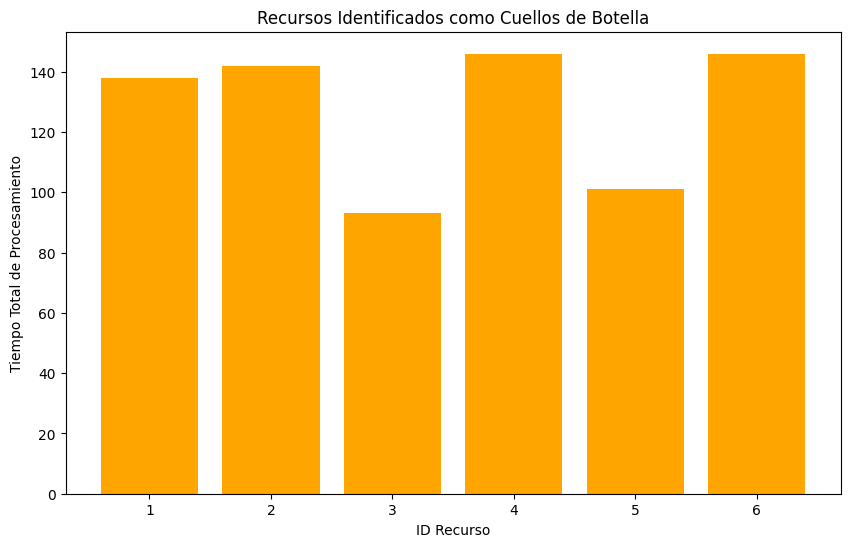

In [ ]:
# Visualizamos los cuellos de botella
visualizar_cuellos_de_botella(cuellos_de_botella)

### 3. Visualización diagrama Gantt

In [ ]:
# Función para visualizar el diagrama de Gantt
def visualizar_gantt(df_ordenes, df_operaciones):

    # Creamos un DataFrame vacío para almacenar los datos del diagrama de Gantt
    df_gantt = pd.DataFrame(columns=['ID Orden', 'ID Operación', 'Operación', 'Recurso', 'Start', 'Finish'])
    # Creamos un DataFrame vacío para almacenar los datos de holgura
    df_holgura = pd.DataFrame(columns=['ID Orden', 'Operación', 'Start', 'Finish'])

    # Inicializamos el tiempo de inicio para cada recurso
    inicio_recursos = {recurso: datetime(2024, 5, 1, 8, 0) for recurso in recursos['ID Recurso']}

    # Iteramos sobre cada operación en el DataFrame de operaciones
    #for _, operacion in df_operaciones.iterrows():
    for tarea in cuellos_de_botella:
        id_orden, id_operacion, id_recurso = tarea
        # Obtenemos los detalles de la operación y el recurso asignado
        #id_orden = operacion['ID Orden']
        #id_operacion = operacion['ID Operación']
        #recurso = operacion['ID Recurso']
        id_orden, id_operacion, id_recurso = tarea
        operacion = df_operaciones[(df_operaciones['ID Orden'] == id_orden) &
                                   (df_operaciones['ID Operación'] == id_operacion)].iloc[0]
        duracion = int(operacion['Duración'])
        tiempo_setup = int(operacion['Tiempo Setup'])

        # Calculamos el tiempo de inicio y fin de la operación
        inicio = inicio_recursos[id_recurso]
        fin = inicio + timedelta(hours=duracion)
        inicio_recursos[id_recurso] = fin + timedelta(hours=tiempo_setup)

        # Añadimos los datos de la operación al DataFrame de Gantt
        df_gantt = pd.concat([df_gantt, pd.DataFrame({
            'ID Orden': [id_orden],
            'ID Operación': [id_operacion],
            #'Operación': [f"Orden {id_orden} - {operacion['Descripción Operación']}"],
            'Operación': [operacion['Descripción Operación']],
            #'Recurso': [recurso],
            'Recurso': [operacion['Descripción Recurso']],
            'Start': [inicio],
            'Finish': [fin]
        })], ignore_index=True)

    # Iteramos sobre cada orden en el DataFrame de órdenes
    for _, orden in df_ordenes.iterrows():
        # Añadimos los datos de holgura al DataFrame de holgura
        df_holgura = pd.concat([df_holgura, pd.DataFrame({
            'ID Orden': [orden['ID Orden']],
            'Operación': ['Holgura'],
            'Start': [orden['Fecha Inicio Temprana']],
            'Finish': [orden['Fecha Fin Tardía']]
        })], ignore_index=True)

    # Combinamos los DataFrames de holgura y Gantt
    df_gantt_completo = pd.concat([df_holgura, df_gantt], ignore_index=True)

    # Creamos el diagrama de Gantt usando plotly
    fig = px.timeline(df_gantt_completo, x_start="Start", x_end="Finish", y="ID Orden", text=df_gantt_completo['Operación'], color="Operación", color_discrete_sequence=px.colors.qualitative.Pastel, title="Planificación Gantt de Órdenes de Fabricación")
    # Ordenamos los recursos en el eje y
    fig.update_yaxes(categoryorder="total ascending")
    # Configuramos los títulos de los ejes y otras opciones de diseño
    fig.update_layout(xaxis_title='Tiempo', yaxis_title='Recurso', hovermode="closest", showlegend=True)

    # Personalizamos el color de la barra de holgura
    fig.data[0].marker.color = 'gray'
    fig.data[0].hoverinfo = 'none'  # Deshabilitamos el hover para la barra de holgura

    # Mostramos el gráfico
    fig.show()


In [ ]:
# Visualizamos el diagrama de Gantt
visualizar_gantt(ordenes, operaciones)

NameError: name 'cuellos_de_botella' is not defined